<a href="https://colab.research.google.com/github/ArpitKadam/Attention-Is-All-You-Code/blob/main/LLM-from-Scratch/CHP_10_Measuring_the_LLM_loss_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREVIOUSLY**

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

In [6]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
    )

  def forward(self, x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, drop_rate, num_heads, qkv_bias):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(drop_rate)
    self.register_buffer("simple_mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    batch, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = torch.matmul(queries, keys.transpose(2, 3))

    attn_scores.masked_fill_(
        self.simple_mask.bool()[:num_tokens, :num_tokens],
        -torch.inf
    )

    attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)

    attn_weights = self.dropout(attn_weights)

    context_vec = torch.matmul(attn_weights, values)

    context_vec = context_vec.transpose(1, 2)

    context_vec = context_vec.contiguous().view(batch, num_tokens, self.d_out)

    context_vec = self.out_proj(context_vec)

    return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg['emb_dim'],
        d_out = cfg['emb_dim'],
        context_length = cfg['context_length'],
        num_heads = cfg['n_heads'],
        qkv_bias = cfg['qkv_bias'],
        drop_rate = cfg['drop_rate']
      )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    ## Connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    ## Conection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

class GPT_MODEL(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_out = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
    batch_size, seq_length = x.shape

    token_embeddings = self.token_emb(x)
    pos_embeddings = self.pos_emb(torch.arange(seq_length, device=x.device))

    x = token_embeddings + pos_embeddings
    x = self.drop_out(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

In [7]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):

    idx_crop = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_crop)

    logits = logits[:, -1, :]

    probas = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

In [8]:
model = GPT_MODEL(GPT_CONFIG_124M)
model.eval()

GPT_MODEL(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_out): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_fea

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  token_list = token_ids.squeeze(0).tolist()
  decoded_text = tokenizer.decode(token_list)
  return decoded_text

In [13]:
start_context = "Every effort moves"

token_ids = generate_text_simple(model, text_to_token_ids(start_context, tokenizer), 3, 256)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves Gupta C TOTAL


# **CALCULATING THE TEXT GENERATION LOSS: CROSS-ENTROPY AND PERPLEXITY**

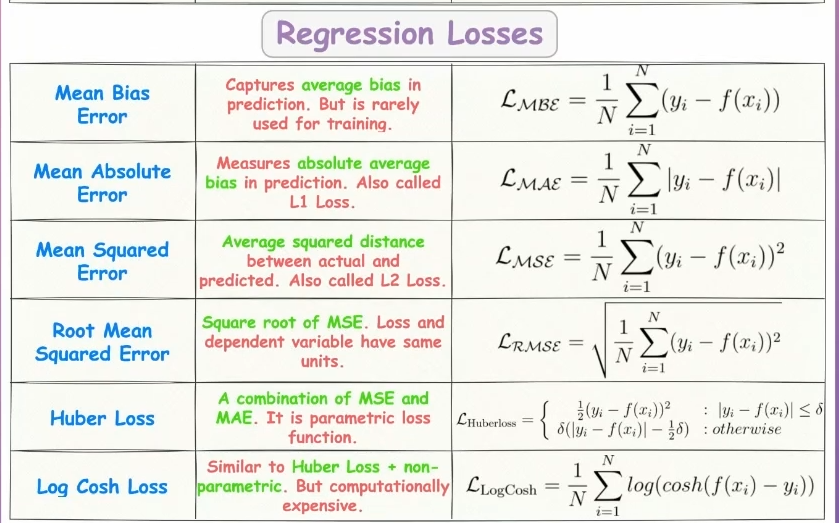

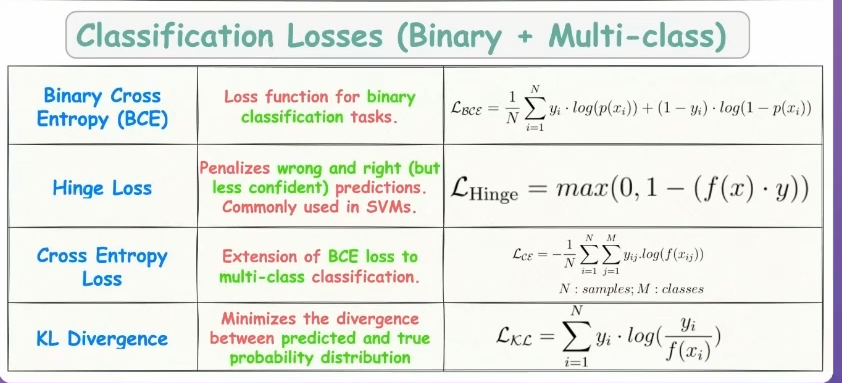

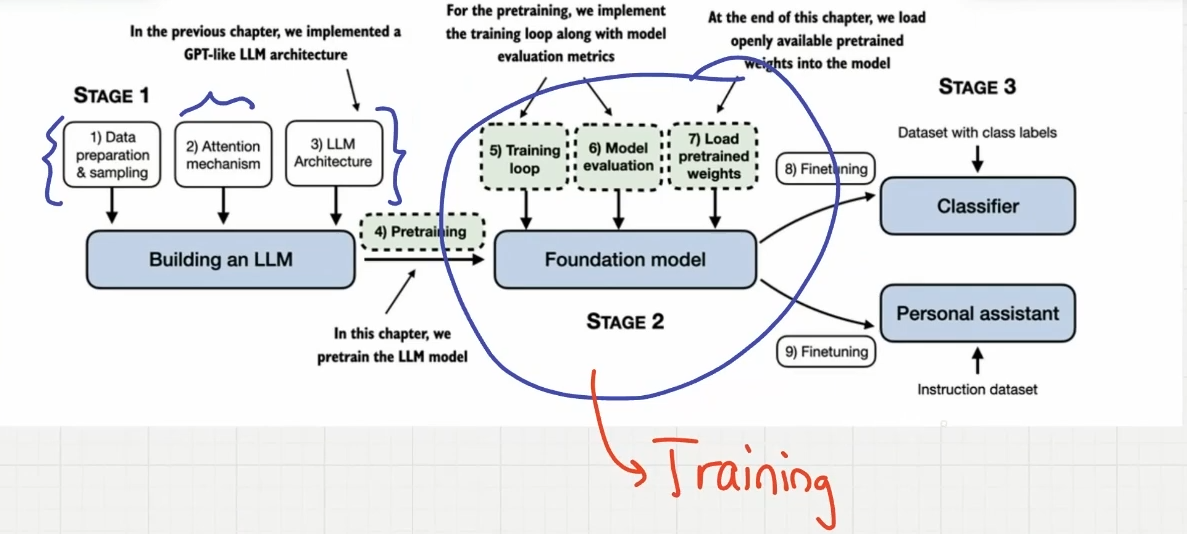

In [14]:
inputs = torch.tensor([[16833, 3626, 6100],     ## Every effort moves
                       [40,    1107,  588]])    ## I really like

targets = torch.tensor([[3626, 6100,   345],    ## effort moves you
                        [1107,  588, 11311]])   ## really like chocolate

In [47]:
with torch.no_grad():
  logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [48]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)

tensor([[[48359],
         [23890],
         [12637]],

        [[ 7392],
         [23890],
         [11236]]])


In [49]:
print(f"Target Batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Output Batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Target Batch 1:  effort moves you
Output Batch 1:  colonialism helicoptersReuters


## **CROSS-ENTROPY LOSS**

In [50]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Target Probas for Batch 1: {target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Target Probas for Batch 2: {target_probas_2}")

Target Probas for Batch 1: tensor([3.4215e-05, 2.9748e-05, 1.9471e-05])
Target Probas for Batch 2: tensor([4.8656e-06, 3.2088e-05, 1.3469e-05])


In [51]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(f"Log Probas: {log_probas}")

Log Probas: tensor([-10.2829, -10.4228, -10.8466, -12.2333, -10.3470, -11.2151])


In [52]:
avg_log_probas = torch.mean(log_probas)
print(f"Average Log Probas: {avg_log_probas}")

Average Log Probas: -10.891270637512207


In [53]:
neg_avg_log_probas = -1 * avg_log_probas
print(f"Negative Average Log Probas: {neg_avg_log_probas}")

Negative Average Log Probas: 10.891270637512207


**We can perform everything we did above in two steps using torch.nn.functional.cross_entropy**

In [54]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print(f"Shape of Logits Flat: {logits_flat.shape}")
print(f"Shape of Targets Flat: {targets_flat.shape}")

Shape of Logits Flat: torch.Size([6, 50257])
Shape of Targets Flat: torch.Size([6])


In [55]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(f"Cross-Entropy Loss: {loss}")

Cross-Entropy Loss: 10.89127254486084


## **PERPLEXITY**

In [58]:
perplexity = torch.exp(loss)
print("Perplexity: ", perplexity)

Perplexity:  tensor(53705.5977)
